# Analisis Kualitas Air - KualaSG
Notebook ini berisi preprocessing, analisis, dan visualisasi data kualitas air untuk Sungai KualaSG.

In [1]:
pip install pandas numpy matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


You should consider upgrading via the 'c:\Users\annisa andriyani\AppData\Local\Programs\Python\Python310\python.exe -m pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Load Data

In [3]:
# Path ke file CSV
file_path = "KualaSgTem_hisdata_alldata_1737750929398.csv"

# Baca file CSV dengan pemisah yang sesuai
df = pd.read_csv(file_path, sep=',')

# Menemukan nama kolom yang mengandung 'time'
time_col = [col for col in df.columns if 'time' in col.lower()][0]

# Bersihkan nama kolom dari karakter tersembunyi
df.columns = df.columns.str.replace(r'[\t\n]', '', regex=True)

# Ubah kolom waktu menjadi format datetime
df.rename(columns={time_col: 'Timestamp'}, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')

# Hapus kolom yang tidak diinginkan jika ada
columns_to_drop = ["COD_Sensor", "BOD_Sensor", "Unnamed: 10",'TDS_Sensor','NH_SEnsor']
df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

# Tampilkan tabel data setelah pembersihan
display(df)



,Timestamp,PH_Sensor,ORP_Sensor,TR_Sensor,CT_Sensor,DO_Sensor
0,2024-10-07 13:48:14.877,29.836,1.024,0.0,28.414,6.472
1,2024-10-07 14:18:14.877,24.972,1.024,0.0,28.414,NaN
2,2024-10-07 14:48:14.877,28.426,1.024,0.0,28.421,NaN
3,2024-10-07 15:18:14.877,23.592,1.024,0.0,28.407,NaN
4,2024-10-07 15:48:14.877,24.357,1.024,0.0,28.386,NaN
...,...,...,...,...,...,...
4221,2024-12-04 10:02:20.141,63.885,1.024,0.0,27.745,7.195
4222,2024-12-04 10:12:20.141,66.071,NaN,0.0,27.840,7.140
4223,2024-12-04 10:22:20.141,67.239,NaN,0.0,NaN,NaN
4224,2024-12-04 10:32:20.141,68.760,1.024,0.0,27.822,7.126


## Visualisasi Distribusi Data

C:\Users\annisa andriyani\AppData\Local\Temp\ipykernel_9468\371997709.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_monthly_count = df[numerical_cols].resample('M').count()


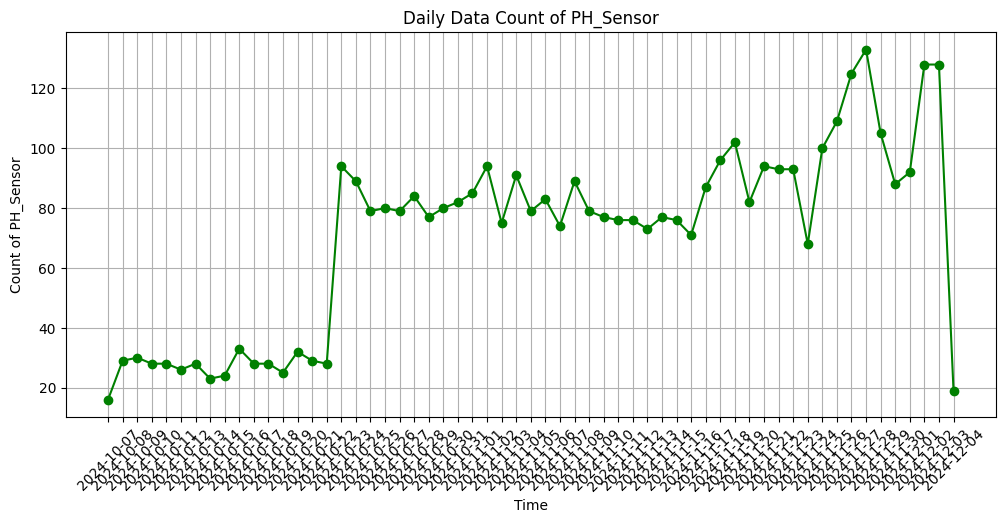

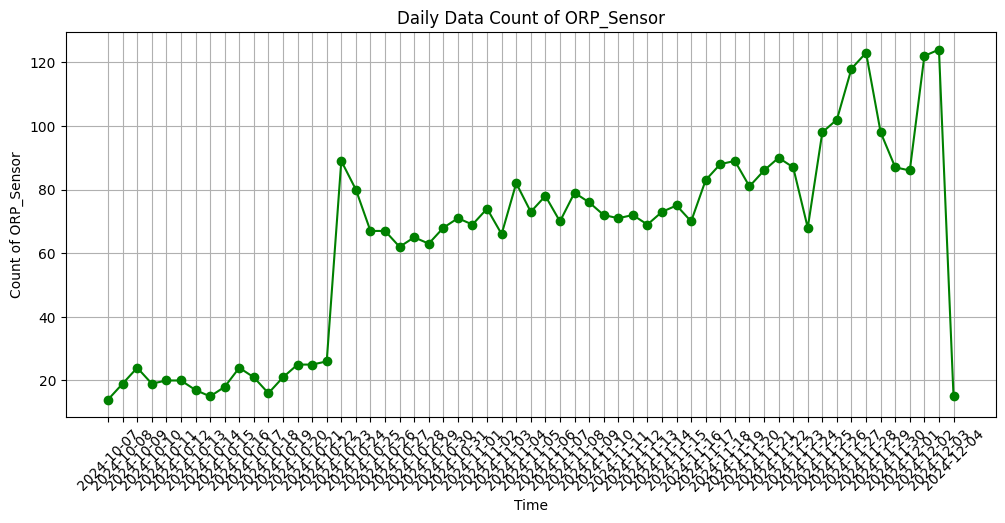

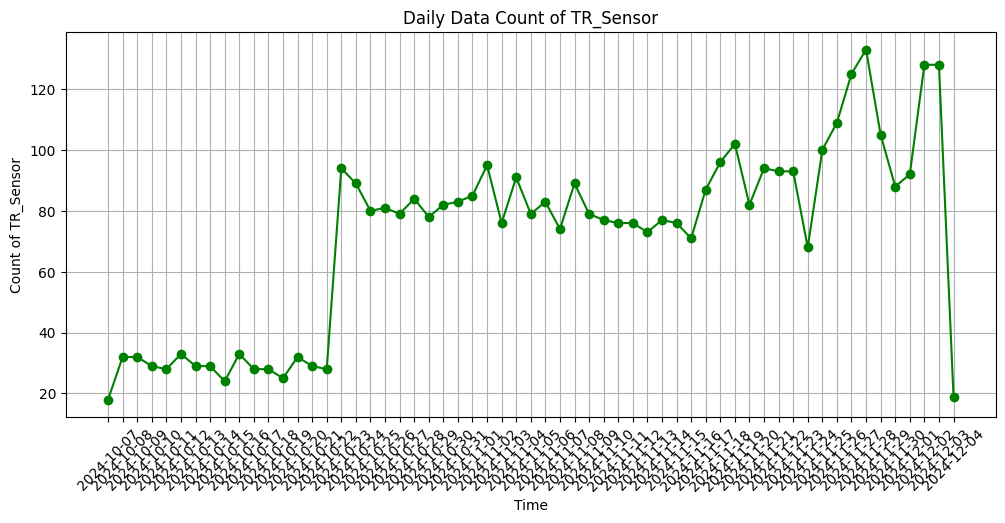

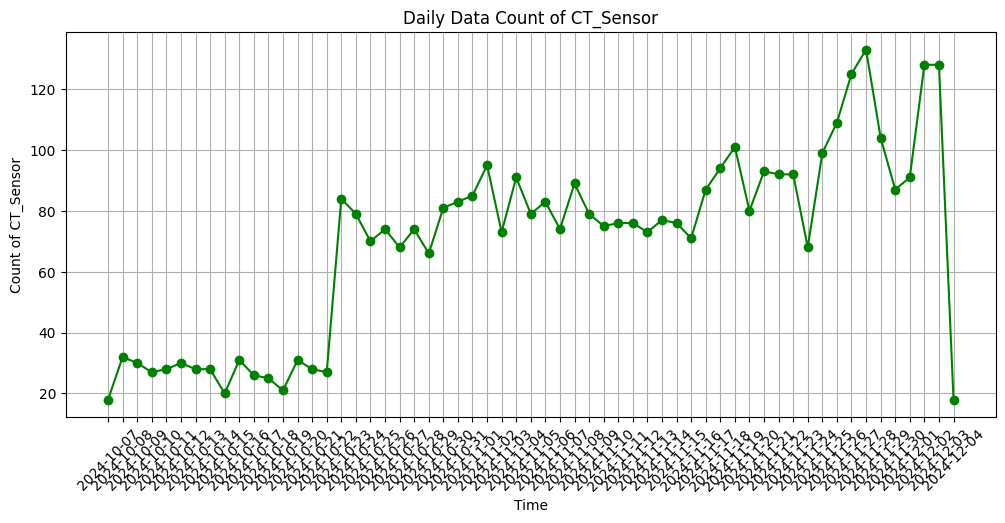

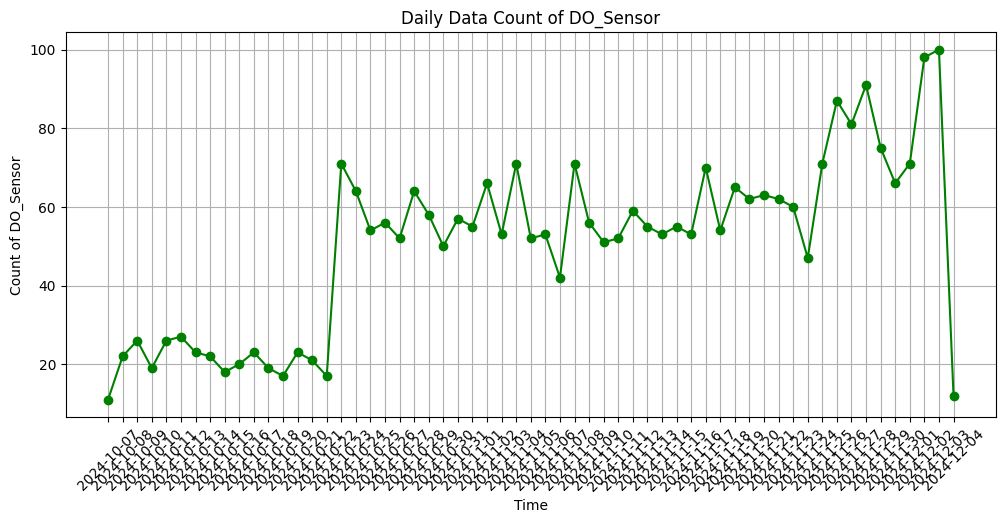

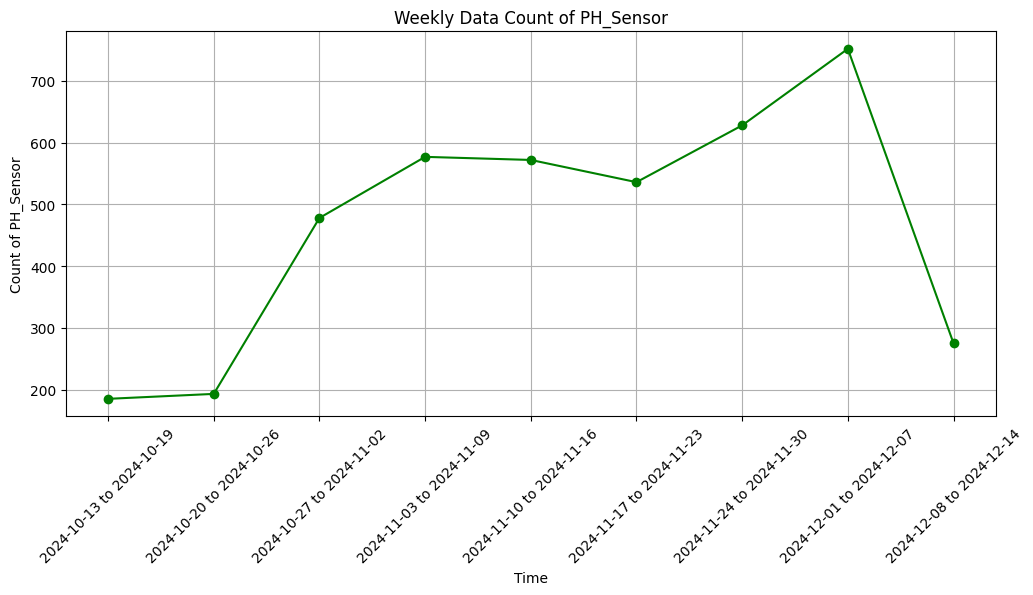

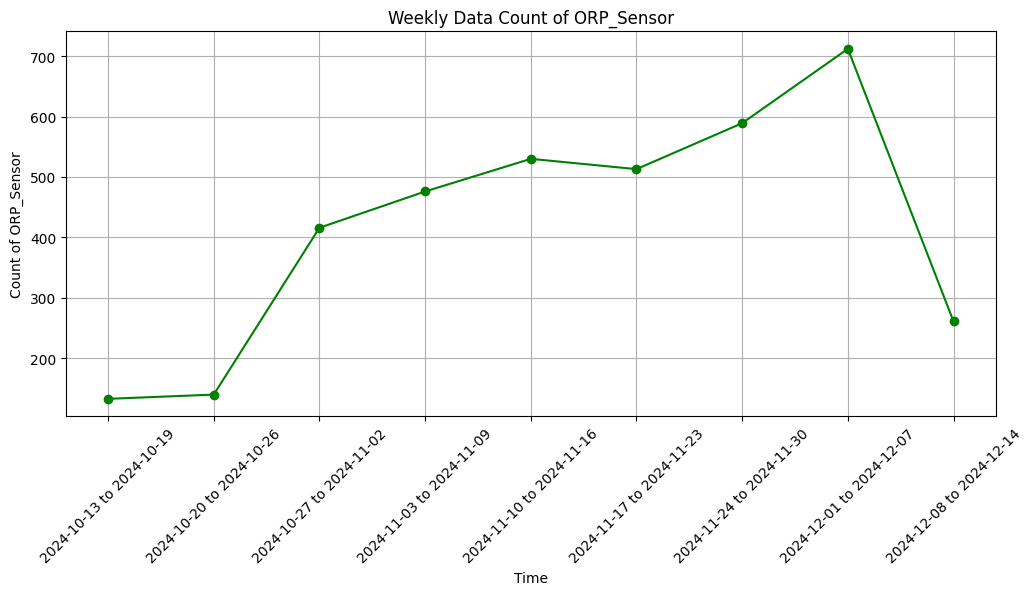

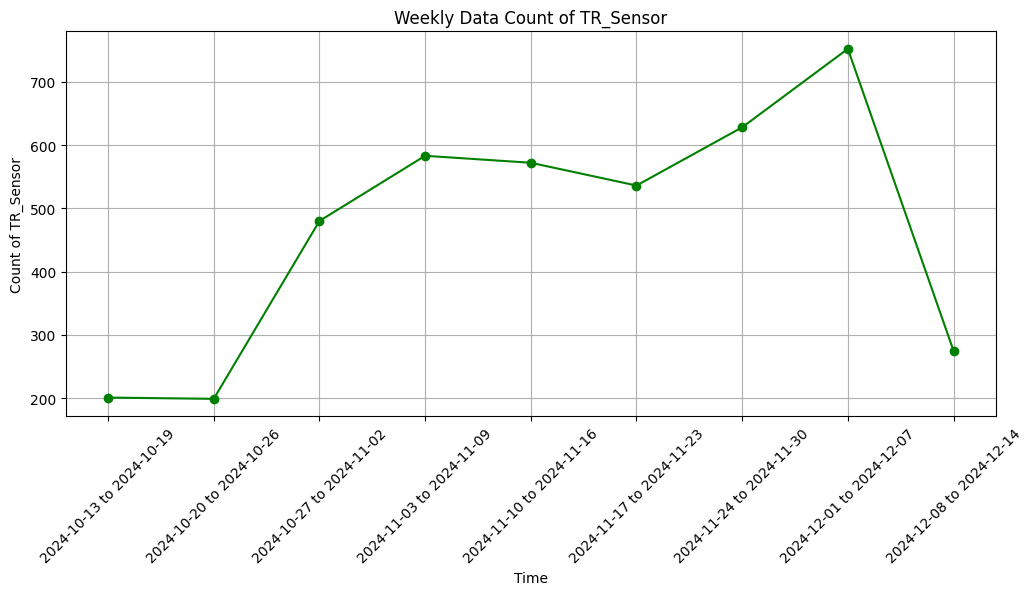

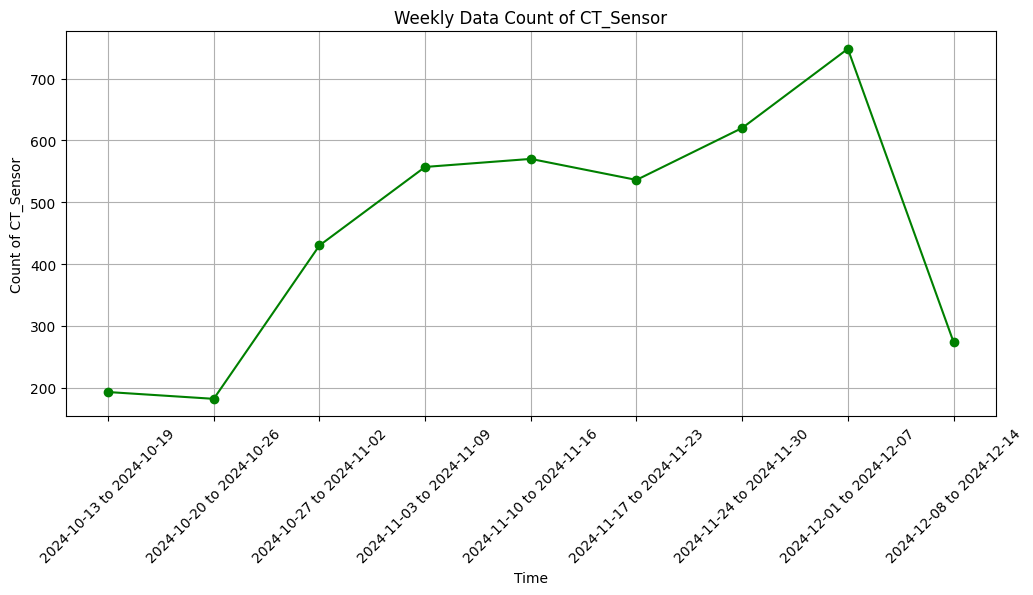

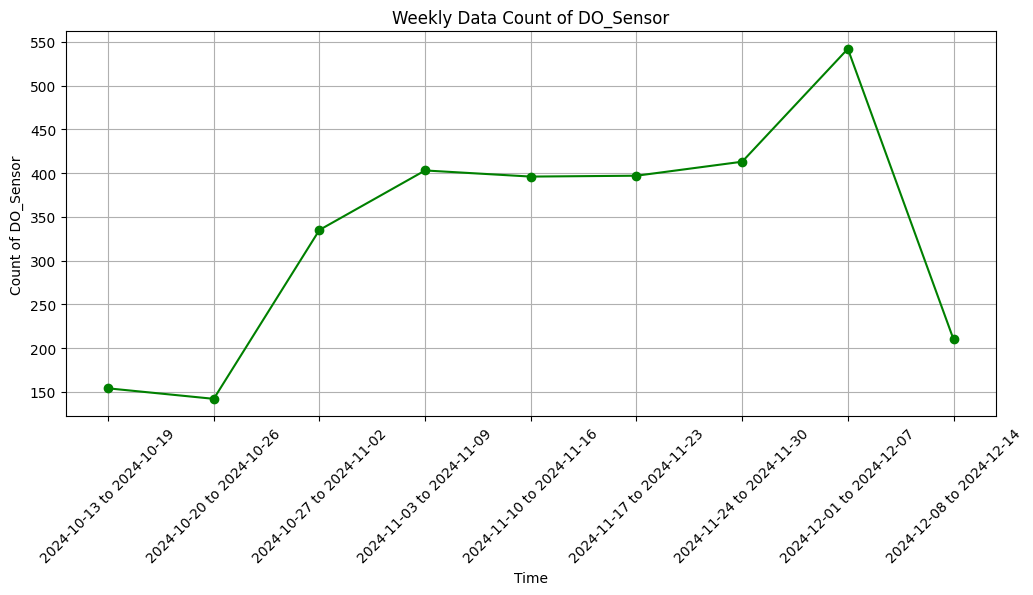

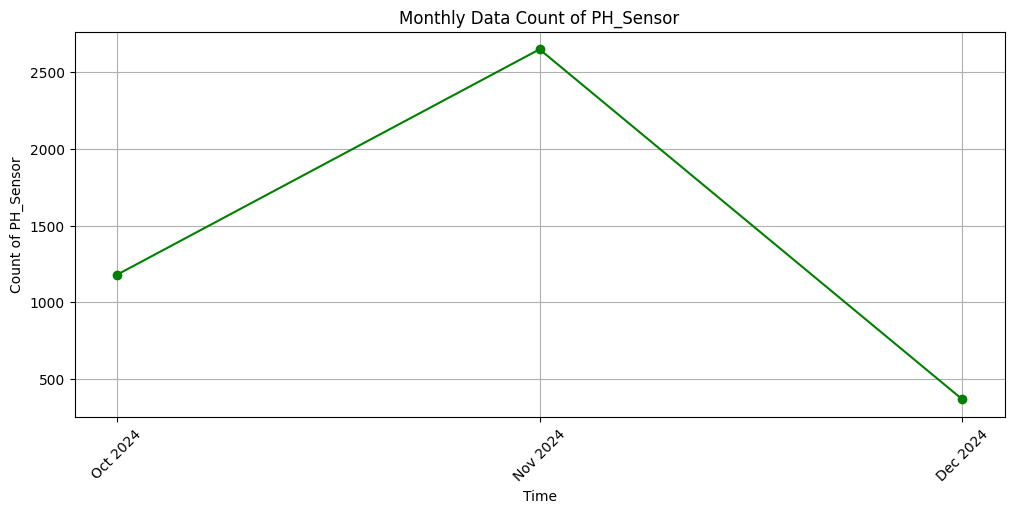

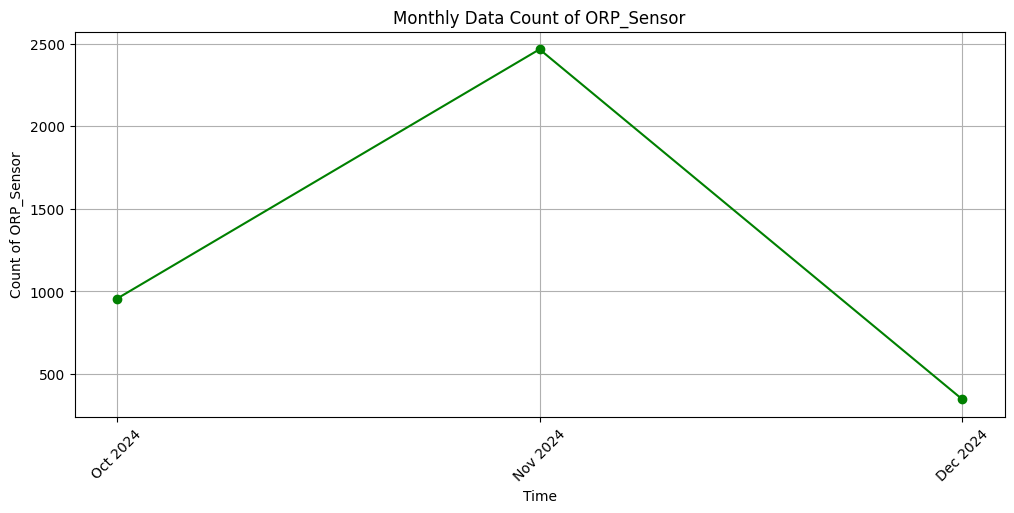

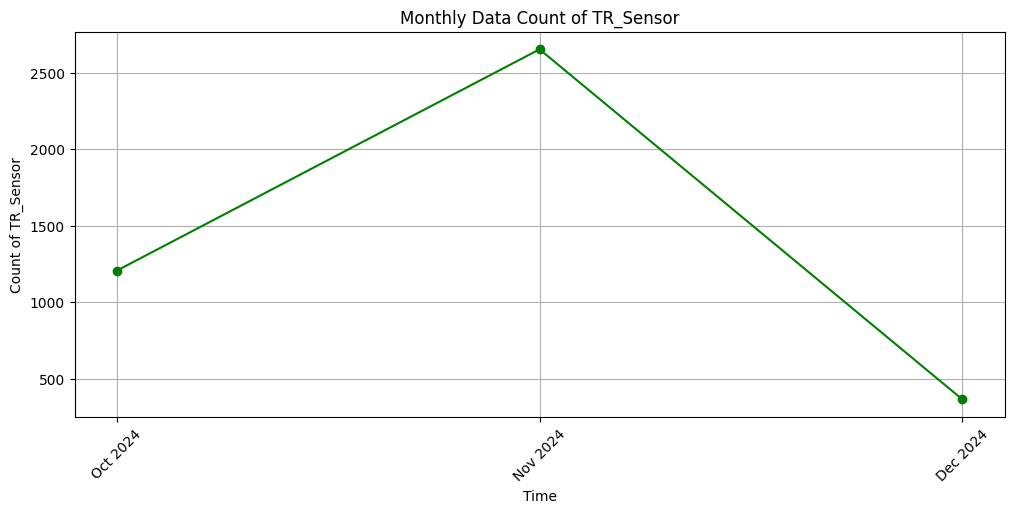

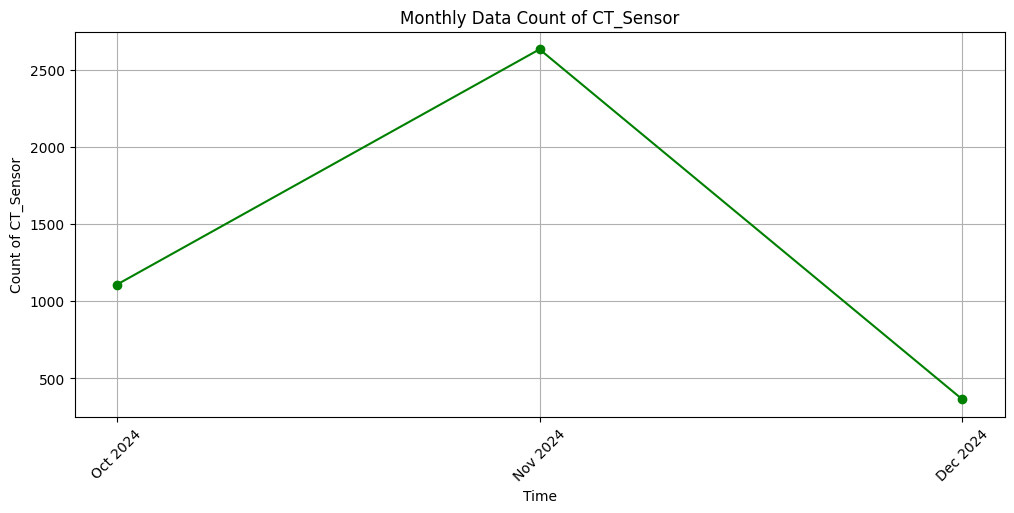

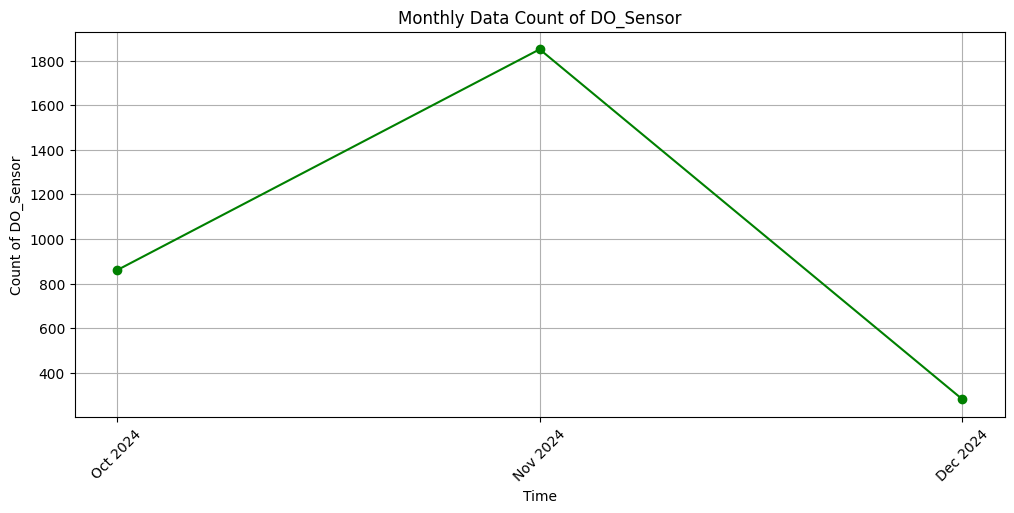

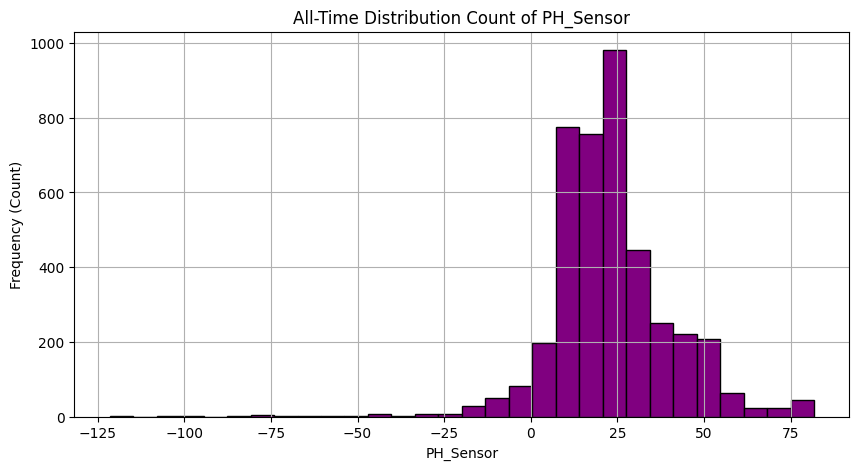

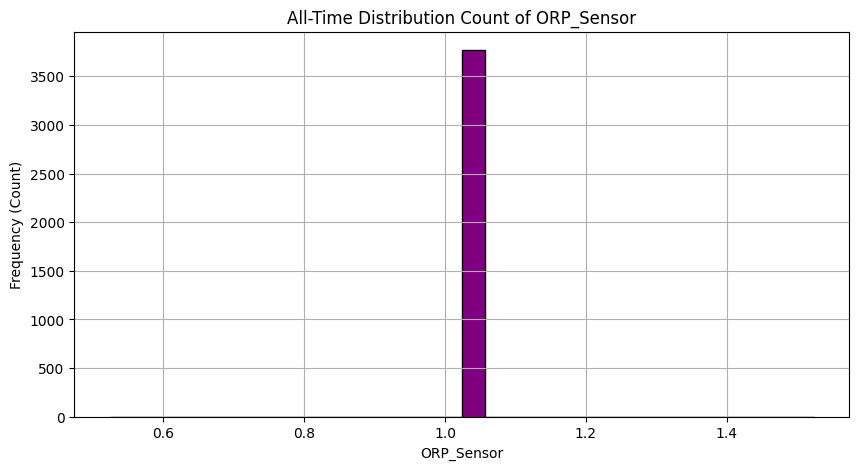

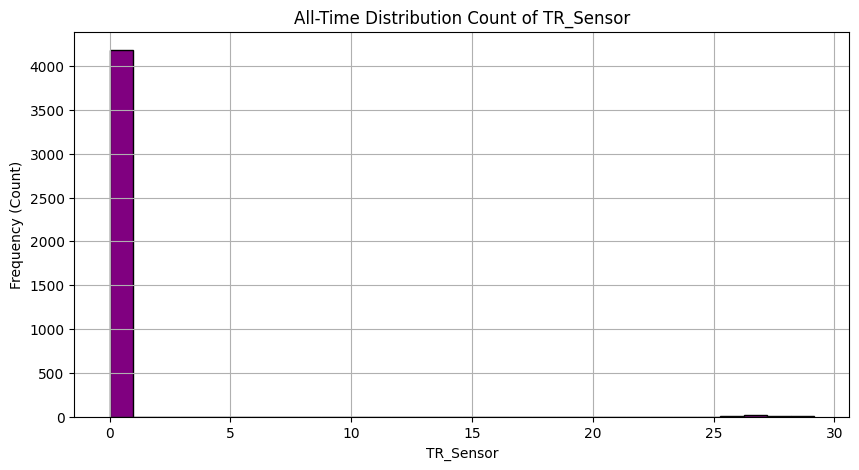

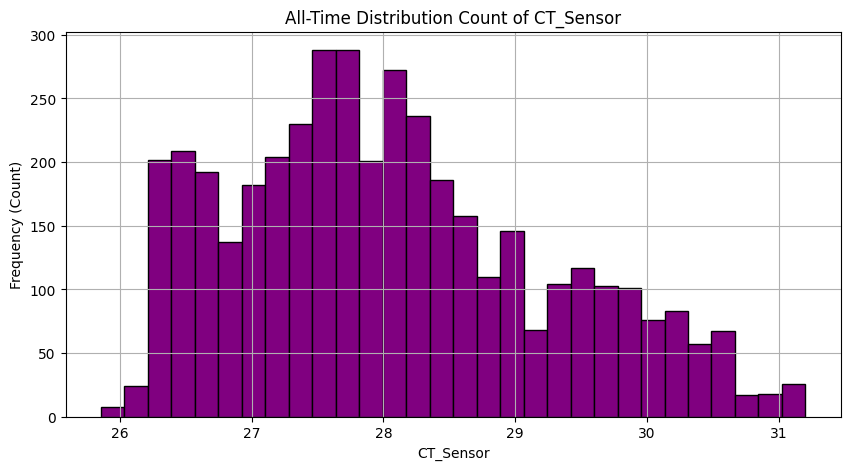

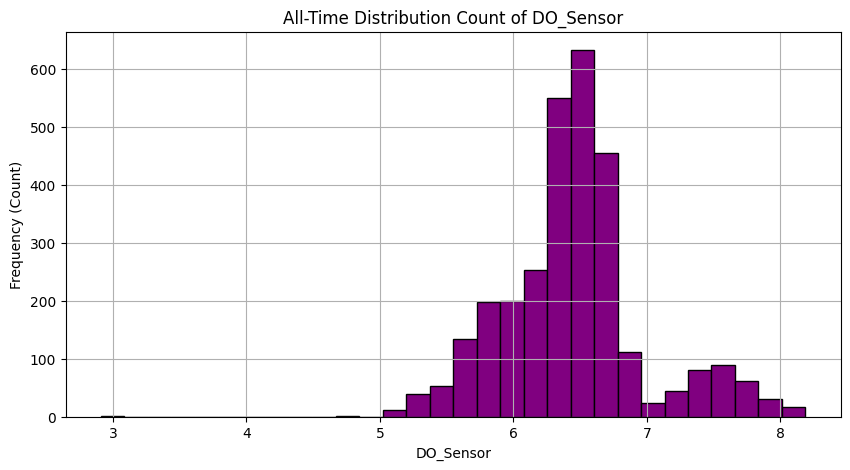

In [ ]:
# Pilih hanya kolom numerik untuk visualisasi
numerical_cols = df.select_dtypes(include=['number']).columns.tolist()

# Gunakan Timestamp sebagai index
df.set_index("Timestamp", inplace=True)

# Buat pengelompokan daily, weekly, monthly berdasarkan count (jumlah data yang ada)
df_daily_count = df[numerical_cols].resample('D').count()
df_weekly_count = df[numerical_cols].resample('W').count()
df_monthly_count = df[numerical_cols].resample('M').count()

# Format indeks waktu agar lebih jelas dalam grafik
df_daily_count.index = df_daily_count.index.strftime("%Y-%m-%d")  # Tampilkan setiap hari
df_weekly_count.index = [f"{idx.strftime('%Y-%m-%d')} to {(idx + pd.Timedelta(days=6)).strftime('%Y-%m-%d')}" for idx in df_weekly_count.index]  # Rentang minggu
df_monthly_count.index = df_monthly_count.index.strftime("%b %Y")  # Nama bulan dan tahun

# Fungsi untuk menampilkan jumlah data dengan format sumbu x yang sesuai
def plot_data_count(grouped_df, title):
    for column in numerical_cols:
        plt.figure(figsize=(12, 5))
        plt.plot(grouped_df.index, grouped_df[column], marker='o', linestyle='-', color='g')
        plt.xlabel("Time")
        plt.ylabel(f"Count of {column}")
        plt.title(f"{title} Data Count of {column}")
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()

# Plot count untuk daily (semua hari ditampilkan)
plot_data_count(df_daily_count, "Daily")

# Plot count untuk weekly (menampilkan rentang minggu)
plot_data_count(df_weekly_count, "Weekly")

# Plot count untuk monthly (hanya menampilkan nama bulan & tahun)
plot_data_count(df_monthly_count, "Monthly")

# Plot histogram untuk distribusi jumlah data dalam all-time
for column in numerical_cols:
    plt.figure(figsize=(10, 5))
    plt.hist(df[column].dropna(), bins=30, edgecolor='black', color='purple')
    plt.xlabel(column)
    plt.ylabel("Frequency (Count)")
    plt.title(f"All-Time Distribution Count of {column}")
    plt.grid()
    plt.show()


## Data Cleaning

In [5]:
# Definisi rentang nilai yang valid untuk setiap parameter
valid_ranges = {
    "PH_Sensor": (0, 14),
    "ORP_Sensor": (-1000, 1000),  
    "TR_Sensor": (0, 1),  
    "CT_Sensor": (0, 100),  
    "DO_Sensor": (0, 20),  
}

# Konversi semua kolom numerik ke float untuk menghindari error
for col in valid_ranges.keys():
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fungsi untuk membersihkan data out-of-range berdasarkan rata-rata harian
def clean_outliers(df, valid_ranges):
    df_cleaned = df.copy()

    for col, (min_val, max_val) in valid_ranges.items():
        if col in df_cleaned.columns:
            # Hitung rata-rata harian hanya dari data dalam range
            daily_mean = df_cleaned[(df_cleaned[col] >= min_val) & (df_cleaned[col] <= max_val)].resample('D')[col].mean()
            
            # Gantilah nilai yang out-of-range dengan rata-rata harian jika tersedia
            def replace_outliers(row):
                if pd.notna(row[col]) and (row[col] < min_val or row[col] > max_val):
                    return daily_mean.get(row.name.date(), None)  # Ambil nilai mean dari hari yang sama jika ada
                return row[col]

            df_cleaned[col] = df_cleaned.apply(replace_outliers, axis=1)

    return df_cleaned

# Terapkan pembersihan data
df_cleaned = clean_outliers(df, valid_ranges)

# Hapus baris yang memiliki semua kolom kosong
df_cleaned.dropna(how='all', inplace=True)

# Hapus baris yang memiliki lebih dari 50% kolom kosong
threshold = 0.5 * len(df_cleaned.columns)  # Jika lebih dari 50% kolom kosong, hapus barisnya
df_cleaned.dropna(thresh=threshold, inplace=True)

# Hapus baris yang memiliki setidaknya satu kolom utama kosong
essential_columns = list(valid_ranges.keys())  # Pastikan kolom utama memiliki nilai
df_cleaned.dropna(subset=essential_columns, inplace=True)

# Simpan data yang telah dibersihkan ke file CSV
cleaned_file_path = "KualaSg_Cleaned.csv"
df_cleaned.to_csv(cleaned_file_path, index=True)

# Tampilkan data yang sudah dibersihkan
display(df_cleaned)

print(f"Data yang sudah dibersihkan telah disimpan di: {cleaned_file_path}")


,PH_Sensor,ORP_Sensor,TR_Sensor,CT_Sensor,DO_Sensor
Timestamp,,,,,
2024-10-20 08:40:14.096,13.169,1.024,0.0,27.741,6.604
2024-10-20 09:10:14.096,13.159,1.024,0.0,27.704,6.609
2024-10-20 10:10:14.096,9.523,1.024,0.0,27.735,6.733
2024-10-20 10:40:14.096,12.182,1.024,0.0,27.772,6.718
2024-10-20 12:40:14.096,12.091,1.024,0.0,27.926,6.832
...,...,...,...,...,...
2024-11-30 21:26:04.084,8.254,1.024,0.0,26.859,7.452
2024-11-30 21:36:04.084,2.061,1.024,0.0,26.849,7.768
2024-12-01 09:25:26.121,1.648,1.024,0.0,26.606,7.109


Data yang sudah dibersihkan telah disimpan di: KualaSg_Cleaned.csv


C:\Users\annisa andriyani\AppData\Local\Temp\ipykernel_9468\64589923.py:16: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_cleaned_monthly_count = df_cleaned[numerical_cols].resample('M').count()


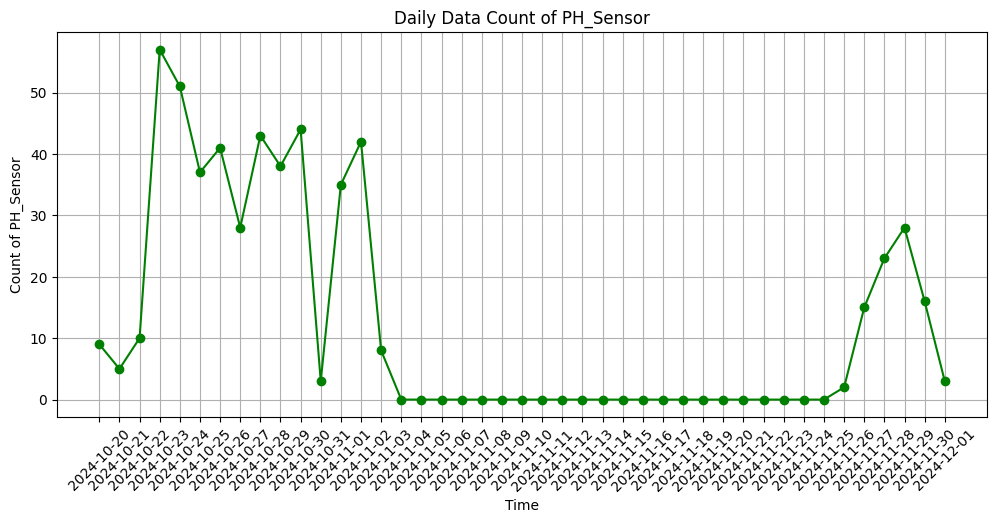

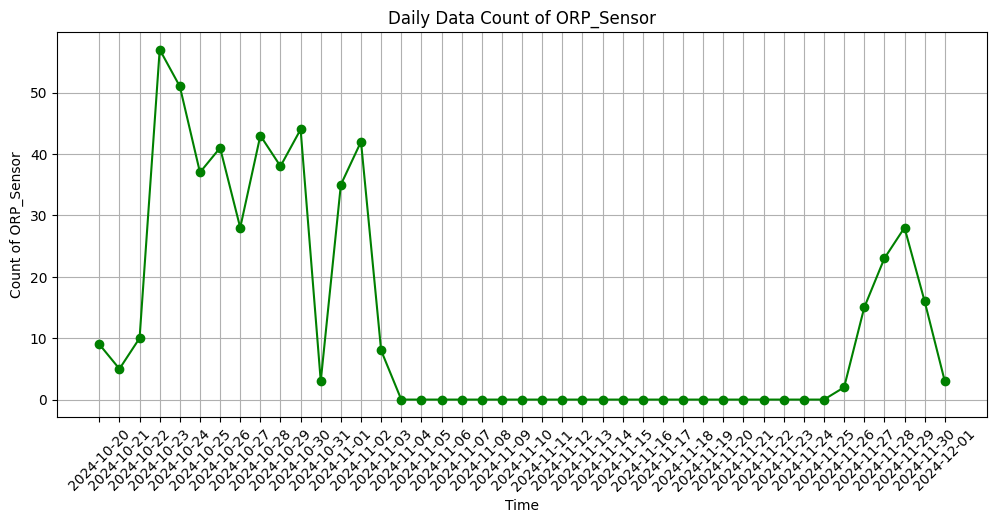

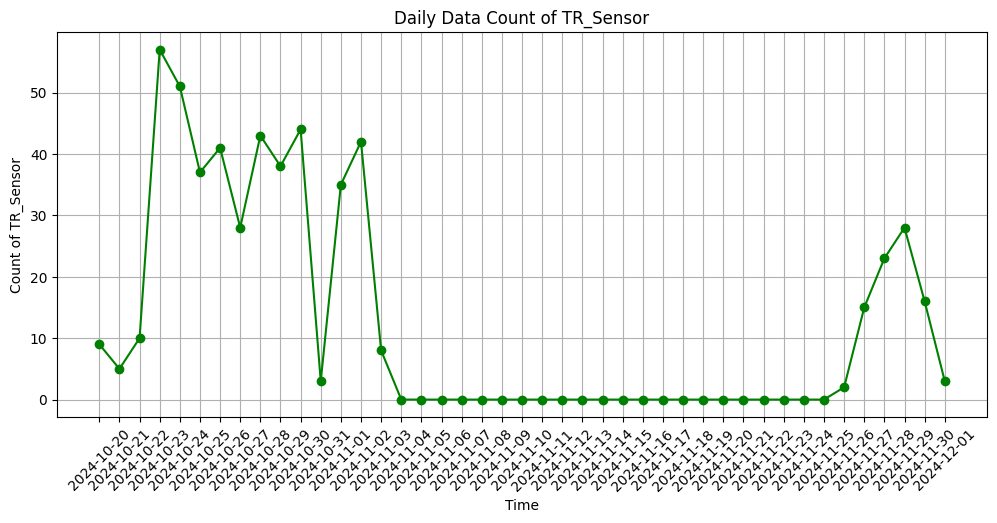

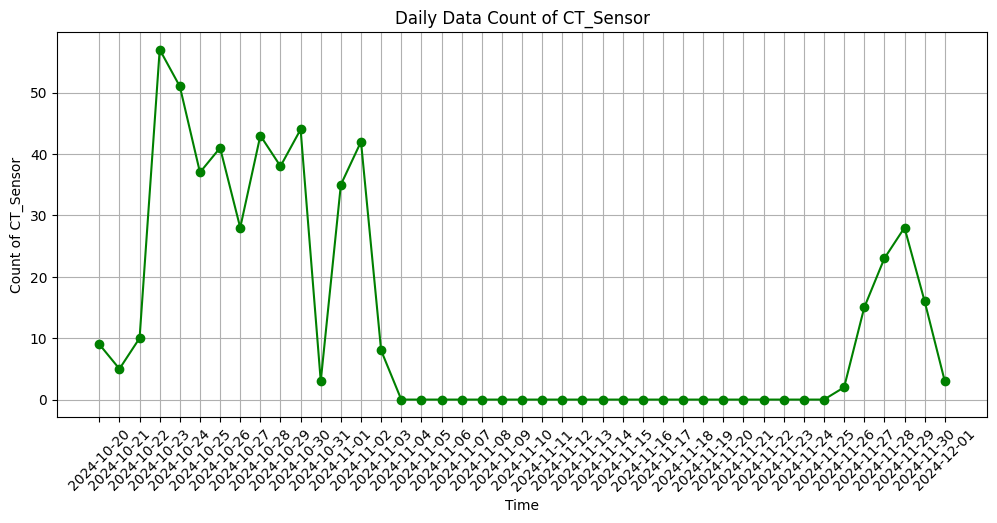

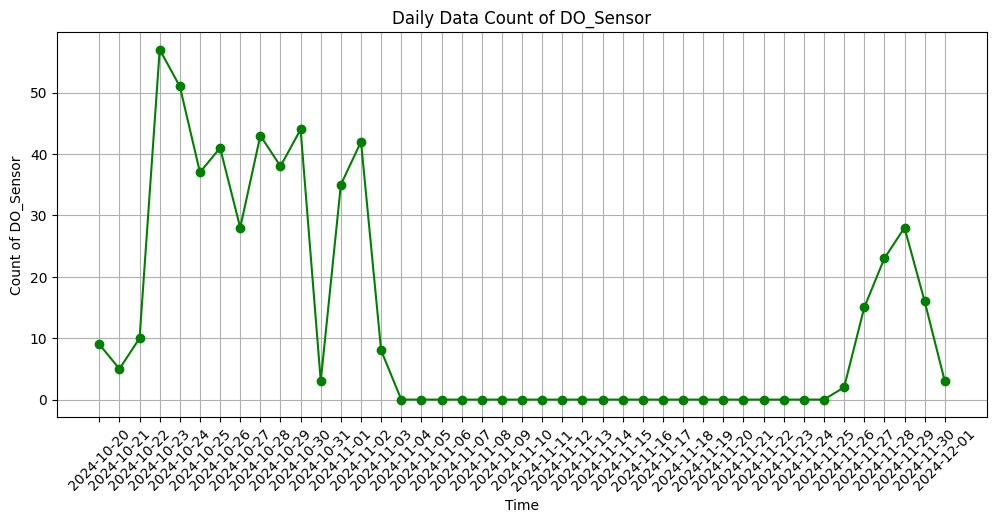

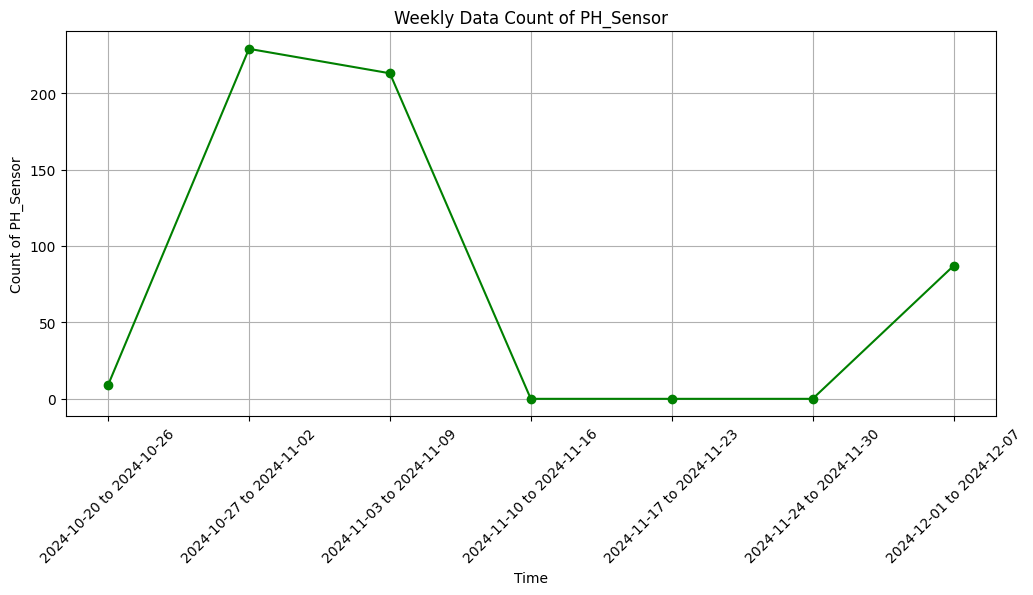

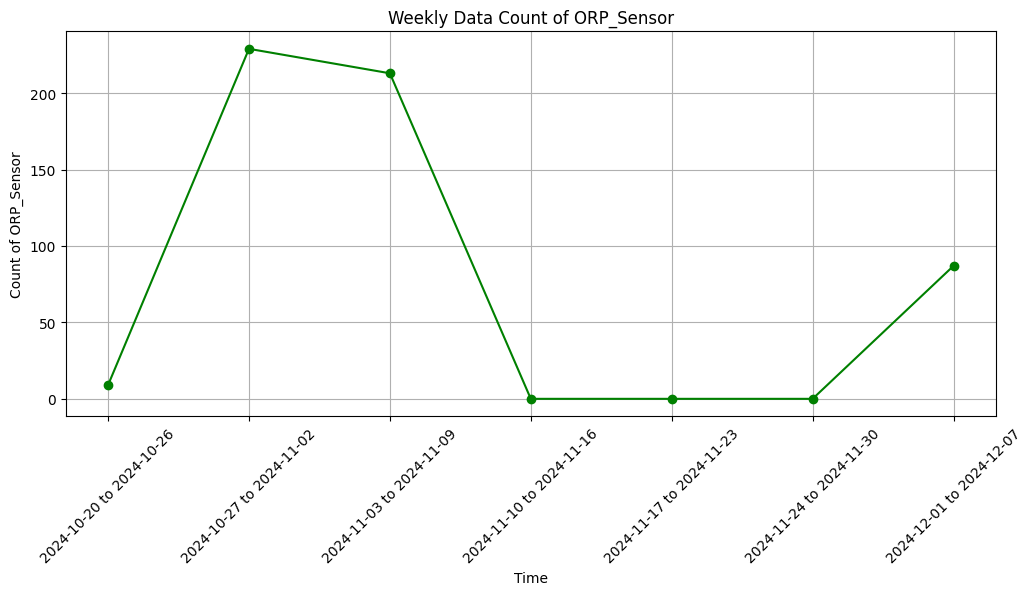

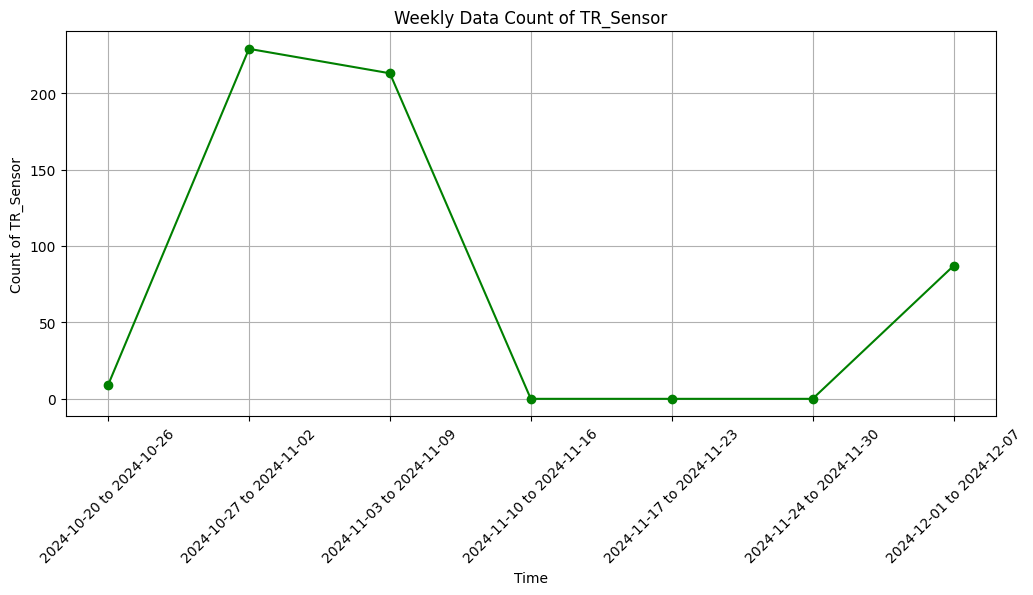

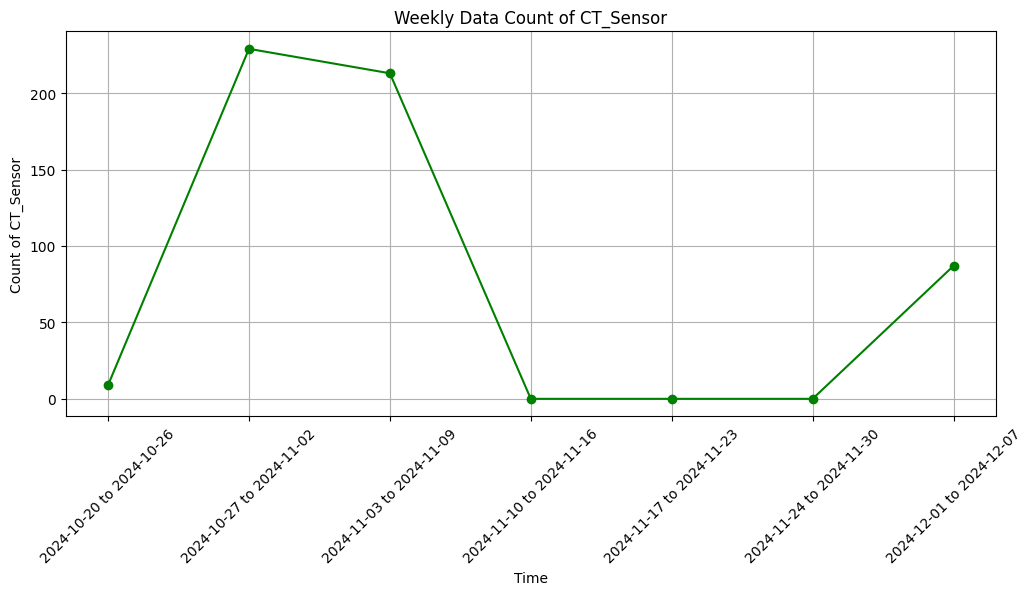

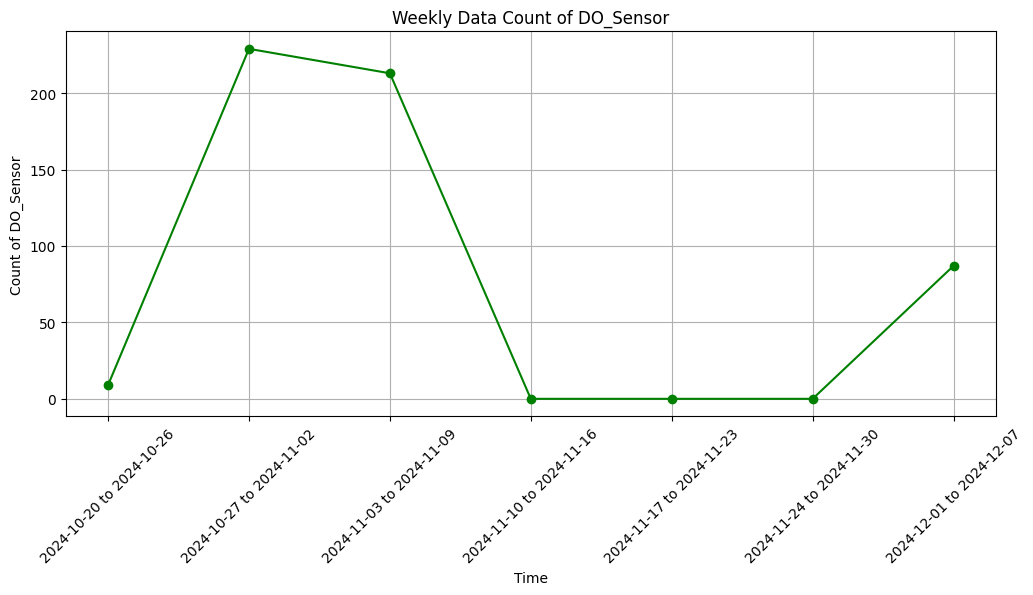

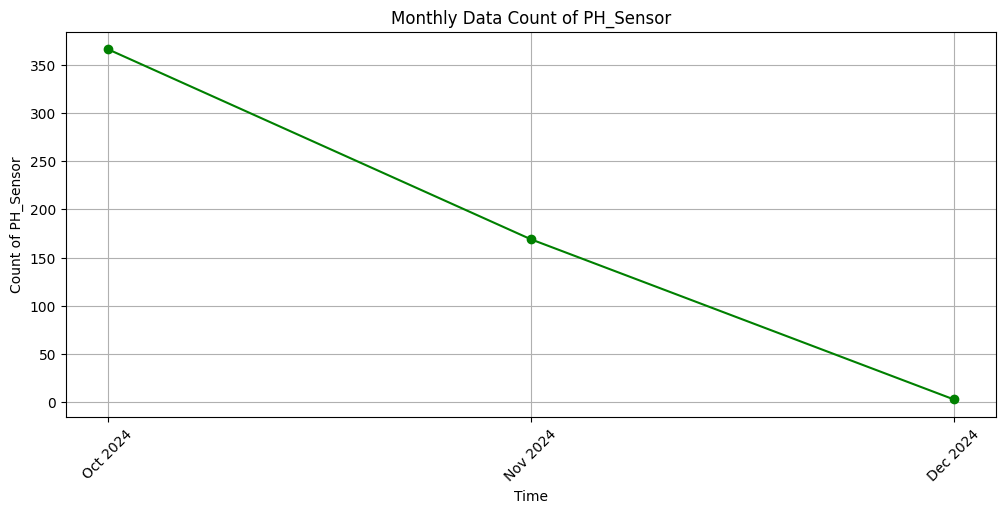

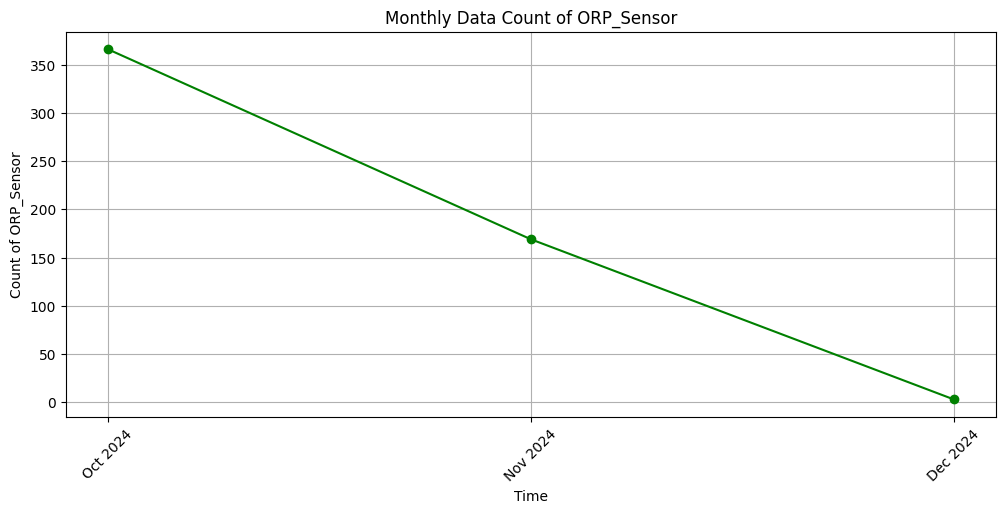

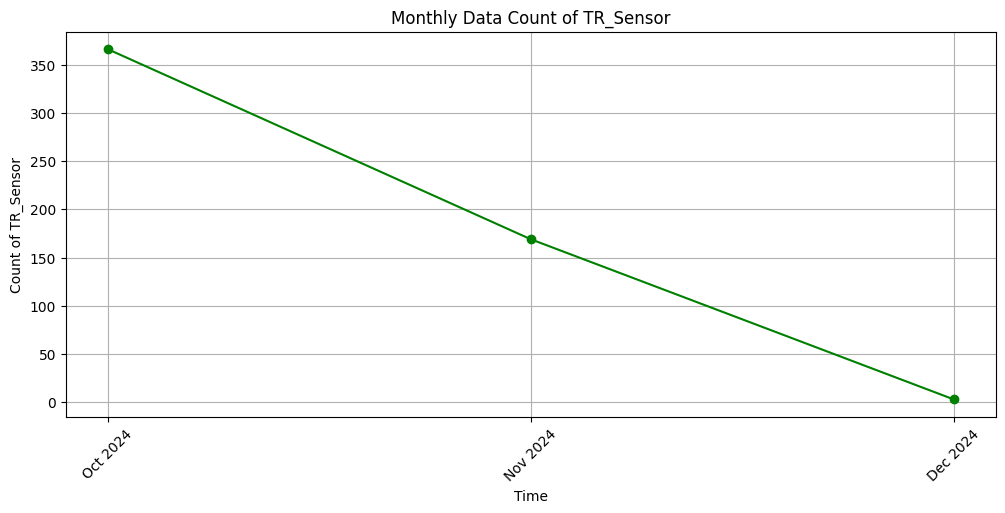

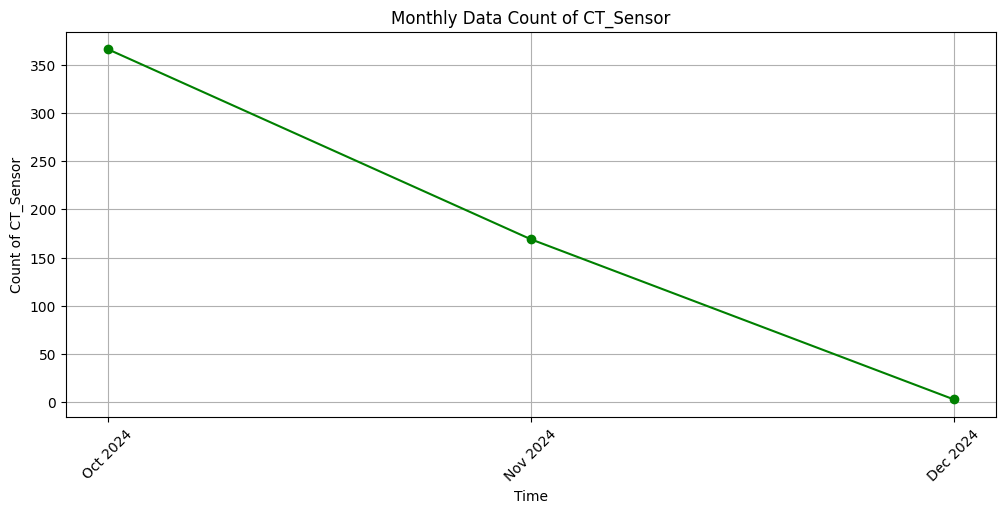

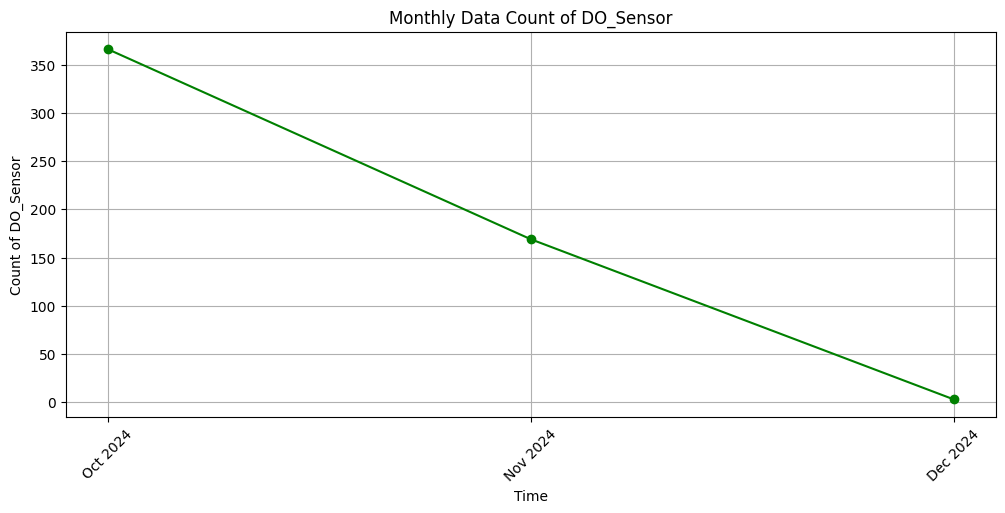

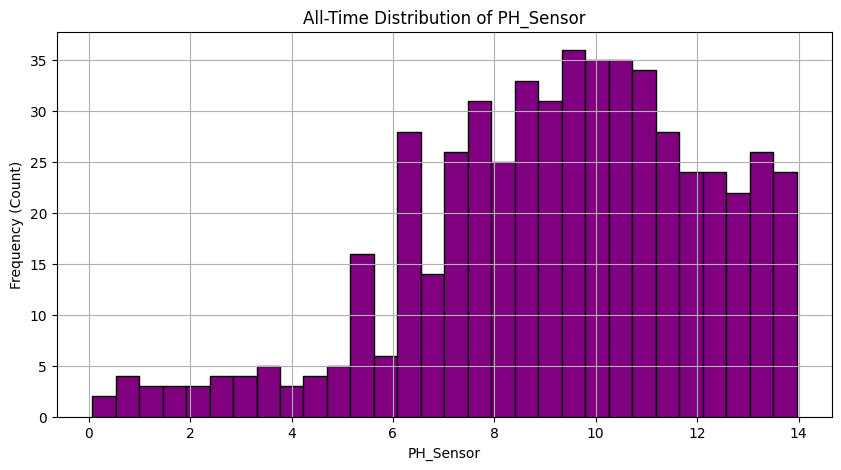

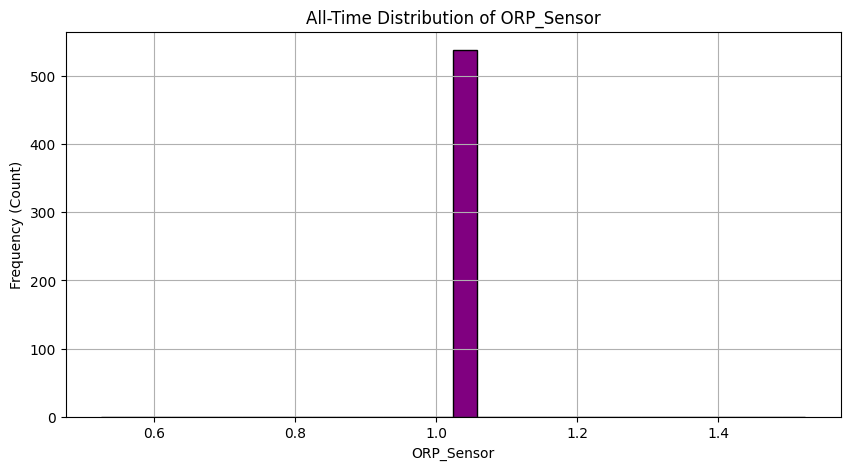

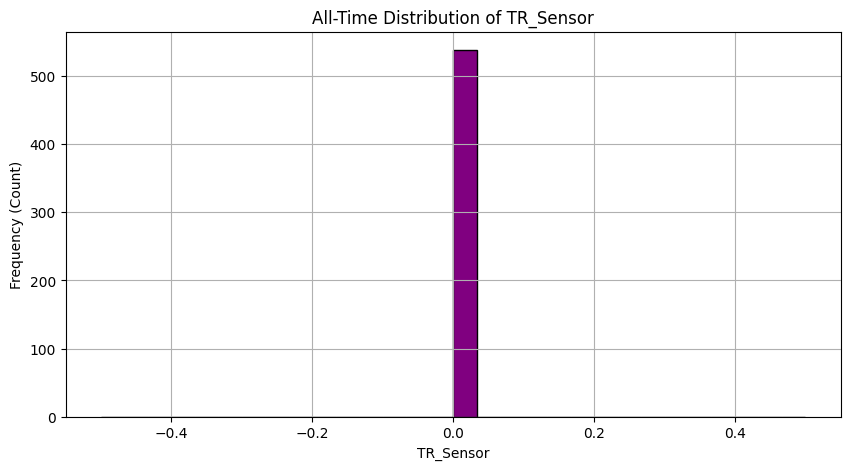

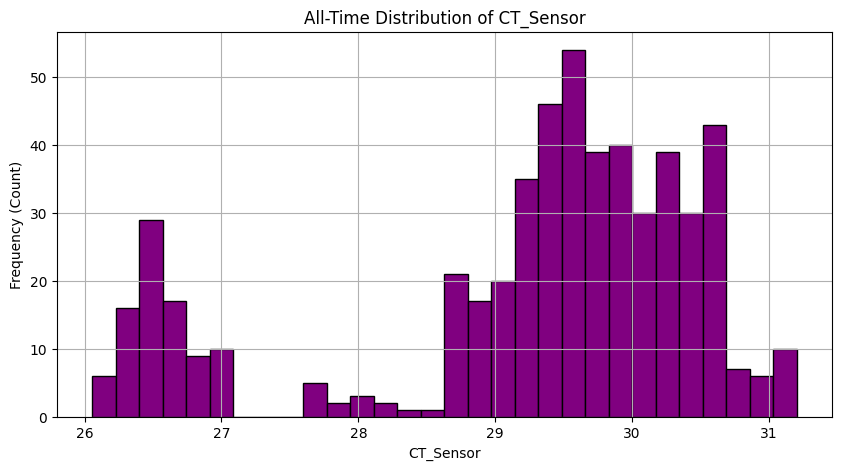

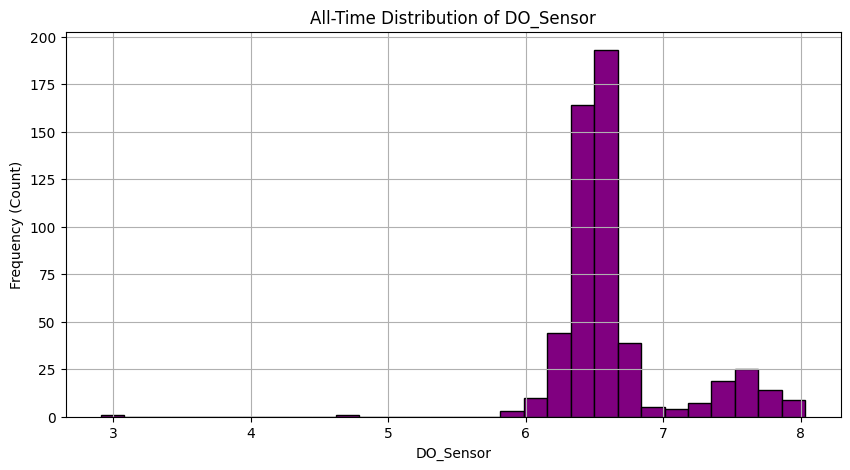

In [8]:
# Path file CSV yang sudah dibersihkan
file_path = "KualaSg_Cleaned.csv"

# Baca file CSV
df_cleaned = pd.read_csv(file_path)

# Pastikan kolom "Timestamp" ada dan dalam format datetime
df_cleaned["Timestamp"] = pd.to_datetime(df_cleaned["Timestamp"], errors='coerce')

# Gunakan Timestamp sebagai index
df_cleaned.set_index("Timestamp", inplace=True)

# Buat pengelompokan daily, weekly, monthly berdasarkan count (jumlah data yang ada)
df_cleaned_daily_count = df_cleaned[numerical_cols].resample('D').count()
df_cleaned_weekly_count = df_cleaned[numerical_cols].resample('W').count()
df_cleaned_monthly_count = df_cleaned[numerical_cols].resample('M').count()

# Format indeks waktu agar lebih jelas dalam grafik
df_cleaned_daily_count.index = df_cleaned_daily_count.index.strftime("%Y-%m-%d")  # Tampilkan setiap hari
df_cleaned_weekly_count.index = [f"{idx.strftime('%Y-%m-%d')} to {(idx + pd.Timedelta(days=6)).strftime('%Y-%m-%d')}" for idx in df_cleaned_weekly_count.index]  # Rentang minggu
df_cleaned_monthly_count.index = df_cleaned_monthly_count.index.strftime("%b %Y")  # Nama bulan dan tahun

# Fungsi untuk menampilkan jumlah data dengan format sumbu x yang sesuai
def plot_data_count(grouped_df, title):
    for column in numerical_cols:
        plt.figure(figsize=(12, 5))
        plt.plot(grouped_df.index, grouped_df[column], marker='o', linestyle='-', color='g')
        plt.xlabel("Time")
        plt.ylabel(f"Count of {column}")
        plt.title(f"{title} Data Count of {column}")
        plt.xticks(rotation=45)
        plt.grid()
        plt.show()

# Plot count untuk daily (semua hari ditampilkan)
plot_data_count(df_cleaned_daily_count, "Daily")

# Plot count untuk weekly (menampilkan rentang minggu)
plot_data_count(df_cleaned_weekly_count, "Weekly")

# Plot count untuk monthly (hanya menampilkan nama bulan & tahun)
plot_data_count(df_cleaned_monthly_count, "Monthly")


# Plot histogram untuk distribusi all-time
for column in df_cleaned.columns:
    plt.figure(figsize=(10, 5))
    plt.hist(df_cleaned[column].dropna(), bins=30, edgecolor='black', color='purple')
    plt.xlabel(column)
    plt.ylabel("Frequency (Count)")
    plt.title(f"All-Time Distribution of {column}")
    plt.grid()
    plt.show()


In [7]:
df_cleaned.count()

PH_Sensor     538
ORP_Sensor    538
TR_Sensor     538
CT_Sensor     538
DO_Sensor     538
dtype: int64